# Chapter 5. Generalized Linear Models: Completion Percentage Over Expected

In the case of ball carriers, you adjusted for the situation (such as down, distance, yards to go) to calibrate individual player statistics on the play level, and later the season level. This approach clearly can be applied to the passing game, and more specifically, quarterbacks. As discussed in Chapter 3, Minnesota quarterback Sam Bradford set the NFL record for seasonal completion percentage during the 2016 season, completing a whopping 71.6% of his passes.

Bradford, however, was just a middle-of-the-pack quarterback in terms of efficiency - whether measured by yards per pass attempt, expected points per passing attempt, touchdown passes.

In [4]:
# pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


## Passes that are thrown longer distances are completed at a lower rate.

In [3]:
pbp_py_pass = \
    pbp_py\
    .query('play_type == "pass" & passer_id.notnull() &' +
    'air_yards.notnull()')\
    .reset_index()

In [4]:
sns.set_theme(style="whitegrid", palette="colorblind")

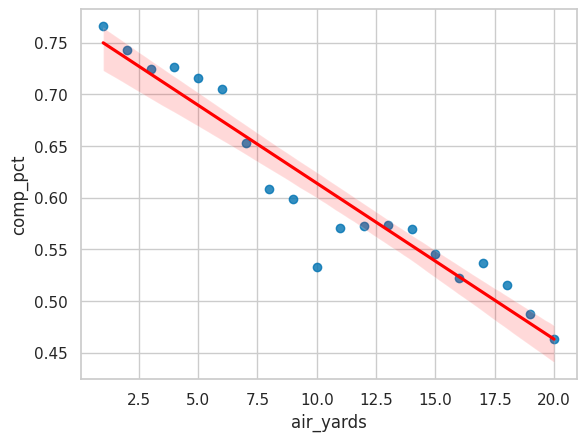

In [5]:
pass_pct_py = \
    pbp_py_pass\
    .query('0 < air_yards <= 20')\
    .groupby('air_yards')\
    .agg({"complete_pass": ["mean"]})

pass_pct_py.columns = \
    list(map('_'.join, pass_pct_py.columns))

pass_pct_py\
    .reset_index(inplace=True)

pass_pct_py\
    .rename(columns={'complete_pass_mean': 'comp_pct'}, inplace=True)

sns.regplot(data=pass_pct_py, x='air_yards', y='comp_pct',
    line_kws={'color': 'red'});
plt.show();

Figure 5-1 and Figure 5-2 clearly show a trend, as expected. Thus, any discussion of quarterback accuracy - as measured by completion percentage - needs to be accompanied by some adjustment for style of play.

Completion percentage over expected, referred to as CPOE in the football analytics world, is one of the adjusted metrics that has made its way into the mainstream.

CPOE ensemble with EPA per passing play has shown to be the most predictive public metric for quarterback play from year-to-year.

There are some issues with measuring quarterback performance this way, which we will touch on at the end of the chapter, but CPOE is here to stay. We will start start the process of walking you through its development using generalized linear models.

## Generalized Linear Models (GLMs)

Some key assumptions of simple linear regression and these assumptions included:
- The assumption the predictor is linearly related to a single dependent variable, or feature.
- The assumption that one predictor variable (simple linear regression) or more predictor variables (multiple regression) describe the dependent variable.
- The distribution of the residuals follows a normal or bell-curve distribution Although almost all datasets violate this last assumption, usually the assumption works “well enough.”

Generalized linear models (or GLMs for short) generalize or extended linear models (the broad name for multiple and simple regressions as well as some other similar models) to relax the previous assumption of normality.

To understand the basic theory behind how GLMs work, look at a completed pass that can either be 1 (completed) or 0 (incomplete). Because there are two possible outcomes, this a binary response and you can assume the a binomial distribution does a “good enough job” of describing the data. 

A normal distribution assumes two parameters: one for the center of the bell-curve (the mean) and a second to describe the width of the the bell-curve (the standard deviation). In contrast, a binomial distribution only requires one parameter: a probability of success. With the pass example, this would be the probability of completing a pass.

However, statistically modeling probability is hard because it is bounded by 0 and 1. So, a link function converts (or “links”) probability (a value ranging from 0 to 1) to value ranging from negavtive infinity to infinity. 

The most common link function is the logit, which gives a name to one the most common types of GLMs, the logistic regression.

In [7]:
complete_ay_py = \
    smf.glm(formula='complete_pass ~ air_yards',
        data=pbp_py_pass,
        family=sm.families.Binomial())\
        .fit();

complete_ay_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               131606
Model:                            GLM   Df Residuals:                   131604
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81070.
Date:                Sun, 02 Jun 2024   Deviance:                   1.6214e+05
Time:                        17:34:10   Pearson chi2:                 1.32e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07017
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0723      0.008    133.319      0.000       1.057       1.088
air_yards     -0.0573      0.001    -91.838      0.000      -0.059      -0.056
==============================================================================
"""

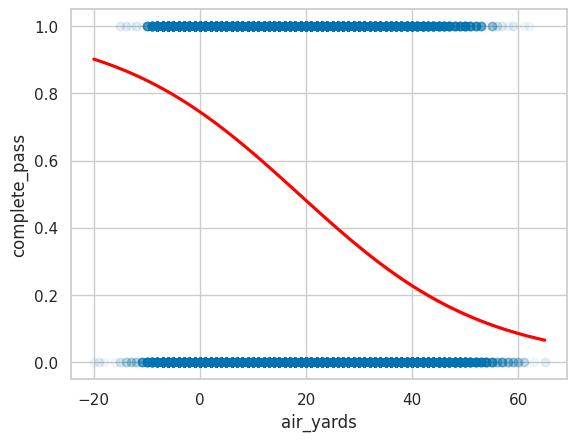

In [8]:
sns.regplot(data=pbp_py_pass, x='air_yards', y='complete_pass',
    logistic=True,
    line_kws={'color': 'red'},
    scatter_kws={'alpha':0.05});

plt.show();

In [9]:
pbp_py_pass["exp_completion"] = \
    complete_ay_py.predict()

pbp_py_pass["cpoe"] = \
    pbp_py_pass["complete_pass"] - \
    pbp_py_pass["exp_completion"]

In [11]:
cpoe_py = \
    pbp_py_pass\
        .groupby(["season", "passer_id", "passer"])\
        .agg({"cpoe": ["count", "mean"],
        "complete_pass": ["mean"]})

cpoe_py.columns = \
    list(map('_'.join, cpoe_py.columns))
    
cpoe_py.reset_index(inplace=True)

cpoe_py = \
    cpoe_py\
        .rename(columns = {"cpoe_count": "n",
        "cpoe_mean": "cpoe",
        "complete_pass_mean": "compl"})\
        .query("n > 100")

print(
    cpoe_py\
    .sort_values("cpoe", ascending=False)
    )

     season   passer_id      passer    n      cpoe     compl
299    2019  00-0020531     D.Brees  406  0.094075  0.756158
193    2018  00-0020531     D.Brees  566  0.086457  0.738516
467    2020  00-0033537    D.Watson  542  0.073442  0.704797
465    2020  00-0033357      T.Hill  121  0.072485  0.727273
22     2016  00-0026143      M.Ryan  631  0.068921  0.702060
..      ...         ...         ...  ...       ...       ...
91     2016  00-0033106      J.Goff  204 -0.108762  0.549020
526    2021  00-0027939    C.Newton  126 -0.109931  0.547619
112    2017  00-0025430   D.Stanton  159 -0.110231  0.496855
730    2022  00-0037327  S.Thompson  150 -0.116826  0.520000
163    2017  00-0031568     B.Petty  112 -0.151871  0.491071

[300 rows x 6 columns]


In [12]:
pbp_py_pass['down'] = pbp_py_pass['down'].astype(str)
pbp_py_pass['qb_hit'] = pbp_py_pass['qb_hit'].astype(str)

pbp_py_pass_no_miss = \
    pbp_py_pass[["passer", "passer_id", "season",
                "down", "qb_hit", "complete_pass",
                "ydstogo", "yardline_100",
                "air_yards",
                "pass_location"]]\
                .dropna(axis = 0)

In [13]:
complete_more_py = \
    smf.glm(formula='complete_pass ~ down * ydstogo + ' +
                'yardline_100 + air_yards + ' +
                'pass_location + qb_hit',
            data=pbp_py_pass_no_miss,
            family=sm.families.Binomial())\
            .fit()

In [15]:
pbp_py_pass_no_miss["exp_completion"] = \
    complete_more_py.predict()

pbp_py_pass_no_miss["cpoe"] = \
    pbp_py_pass_no_miss["complete_pass"] - \
    pbp_py_pass_no_miss["exp_completion"]

In [16]:
cpoe_py_more = \
    pbp_py_pass_no_miss\
    .groupby(["season", "passer_id", "passer"])\
    .agg({"cpoe": ["count", "mean"],
        "complete_pass": ["mean"],
        "exp_completion": ["mean"]})

cpoe_py_more.columns = \
    list(map('_'.join, cpoe_py_more.columns))

cpoe_py_more.reset_index(inplace=True)

cpoe_py_more = \
    cpoe_py_more\
    .rename(columns = {"cpoe_count": "n",
                        "cpoe_mean": "cpoe",
                        "complete_pass_mean": "compl",
                        "exp_completion_mean": "exp_completion"})\
    .query("n > 100")

In [19]:
cpoe_py_more.sort_values("cpoe", ascending=False).head(25)

,season,passer_id,passer,n,cpoe,compl,exp_completion
193,2018,00-0020531,D.Brees,566,0.088907,0.738516,0.649609
299,2019,00-0020531,D.Brees,406,0.087868,0.756158,0.668289
465,2020,00-0033357,T.Hill,121,0.082953,0.727273,0.644320
22,2016,00-0026143,M.Ryan,631,0.077539,0.702060,0.624521
467,2020,00-0033537,D.Watson,542,0.072745,0.704797,0.632052
334,2019,00-0029701,R.Tannehill,343,0.066696,0.690962,0.624266
31,2016,00-0027854,S.Bradford,551,0.061476,0.716878,0.655402
204,2018,00-0023682,R.Fitzpatrick,246,0.061310,0.666667,0.605356
407,2020,00-0023459,A.Rodgers,607,0.061227,0.705107,0.643881
208,2018,00-0026143,M.Ryan,607,0.059653,0.695222,0.635569


In [20]:
cols_keep =\
    ["season", "passer_id", "passer",
    "cpoe", "compl", "exp_completion"]

# create current dataframe
cpoe_now_py =\
    cpoe_py_more[cols_keep].copy()

# create last-year's dataframe
cpoe_last_py =\
    cpoe_now_py[cols_keep].copy()

# rename columns
cpoe_last_py\
    .rename(columns = {'cpoe': 'cpoe_last',
                        'compl': 'compl_last',
                        'exp_completion': 'exp_completion_last'},
                        inplace=True)

# add 1 to season
cpoe_last_py["season"] += 1

In [21]:
cpoe_lag_py =\
    cpoe_now_py\
    .merge(cpoe_last_py,
        how='inner',
        on=['passer_id', 'passer',
        'season'])

In [22]:
cpoe_lag_py[['compl_last', 'compl']].corr()

,compl_last,compl
compl_last,1.000000,0.445661
compl,0.445661,1.000000


In [23]:
cpoe_lag_py[['cpoe_last', 'cpoe']].corr()

,cpoe_last,cpoe
cpoe_last,1.000000,0.465108
cpoe,0.465108,1.000000


In [24]:
cpoe_lag_py[['exp_completion_last', 'exp_completion']].corr()

,exp_completion_last,exp_completion
exp_completion_last,1.0000,0.4711
exp_completion,0.4711,1.0000
